<a href="https://colab.research.google.com/github/brucewuquant/quant_ds_bruce/blob/master/shap_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import shap
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np, pandas as pd, matplotlib.pyplot as plt

Reference: SHAP的理解与应用 - 李桎梏的文章 - 知乎
https://zhuanlan.zhihu.com/p/103370775

https://www.zhihu.com/people/zhigu42/posts


目前我在实际中有三种应用
1.对shap values按特征进行聚和的特征重要度，比模型自带的特征重要度更一致，个人测试如果用shap的特征重要度去筛选变量会稍好些，但不知是否具有普遍性。
2.去除shap interaction values的shap valus可以用于解释x与y的归因关系。
3.单个样本的shap values可以解释该样本的各个特征是如何预测出y的。
我主要还是用2，用shap画出的归因关系基本符合实际的业务解释

In [8]:
X,y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lgb.LGBMClassifier(random_state=124)
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=124, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [3]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

if len(shap_values) == 2:
  shap_values = shap_values[1]

shap_interaction_values = explainer.shap_interaction_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [11]:
# 如果explainer.expected_value得到两个值，则应该为explainer.expected_value[1]
print('解释模型的常数:', explainer.expected_value)
print('训练样本预测值的log odds ratio的均值:', np.log(model.predict_proba(X_train)[:, 1]/ (1 - model.predict_proba(X_train)[:, 1])).mean())
print('常数与归因值之和:', explainer.expected_value + shap_values[0].sum())
print('预测值:', model.predict_proba(X.iloc[0:1])[:, 1][0])
print('预测值的log odds ratio:', np.log(model.predict_proba(X.iloc[0:1])[:, 1][0] / (1 - model.predict_proba(X.iloc[0:1])[:, 1][0])))

解释模型的常数: -2.4423095777560238
训练样本预测值的log odds ratio的均值: -2.4423095777560233
常数与归因值之和: -4.847355639501429
预测值: 0.007787977336637599
预测值的log odds ratio: -4.847355639501424


In [12]:
print('第一个特征的shap values:', shap_values[0][0])
print('第一个特征的shap interaction values:', shap_interaction_values[0][0])
print('第一个特征的shap interaction values和:', shap_interaction_values[0][0].sum())


第一个特征的shap values: 0.6421584573819057
第一个特征的shap interaction values: [ 7.08670205e-01 -2.75670332e-02 -3.07150549e-03  3.78553556e-03
 -4.48776581e-02  6.30889544e-02  8.86423211e-03  4.62361721e-02
 -7.77244230e-02 -3.14386682e-03 -3.23744998e-02  2.72344166e-04]
第一个特征的shap interaction values和: 0.6421584573819054


In [14]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1], X.iloc[1,:])

In [18]:
sample_1_shap = pd.DataFrame(X.iloc[1,:])
sample_1_shap.rename(columns={1: 'feature_value'}, inplace=True)
sample_1_shap['shap_value'] = shap_values[1]
sample_1_shap.sort_values('shap_value', ascending=False)

,feature_value,shap_value
Relationship,4.0,0.989702
Age,50.0,0.906725
Education-Num,13.0,0.890856
Occupation,4.0,0.350074
Marital Status,2.0,0.292875
Race,4.0,0.039939
Country,39.0,0.019464
Sex,1.0,0.016882
Capital Loss,0.0,-0.144477
Workclass,6.0,-0.283428


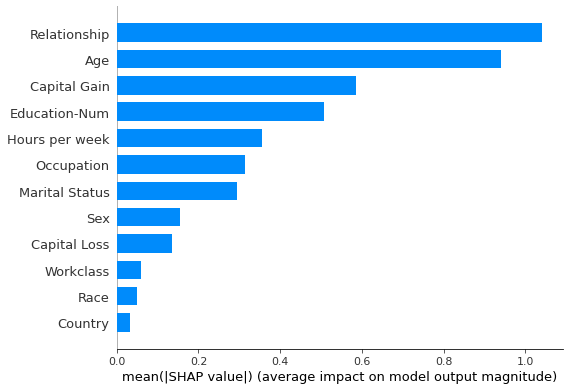

In [19]:
shap.summary_plot(shap_values, X, plot_type="bar")

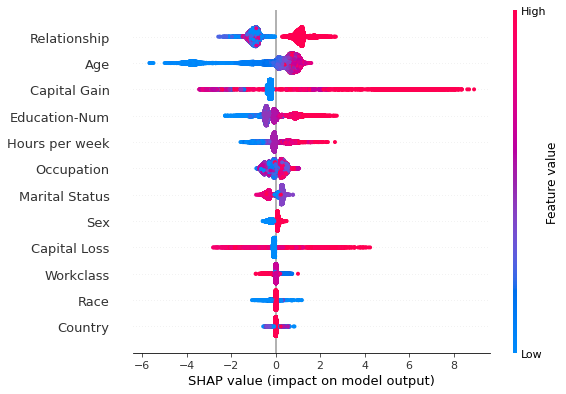

In [20]:
shap.summary_plot(shap_values, X)

In [21]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns
feature_importance['importance'] = np.abs(shap_values).mean(0)
feature_importance.sort_values('importance', ascending=False)


,feature,importance
5,Relationship,1.040163
0,Age,0.939554
8,Capital Gain,0.585915
2,Education-Num,0.506714
10,Hours per week,0.356204
4,Occupation,0.313360
3,Marital Status,0.294948
7,Sex,0.154269
9,Capital Loss,0.135516
1,Workclass,0.058776


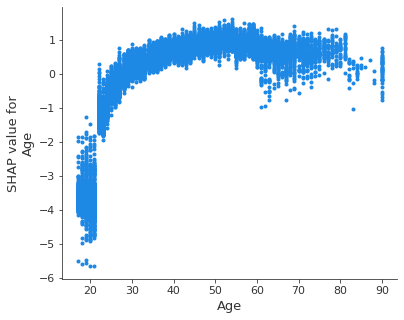

In [22]:
shap.dependence_plot('Age', shap_values, X, interaction_index=None)

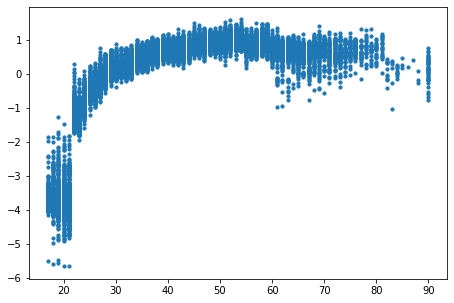

In [25]:
plt.figure(figsize=(7.5, 5))
plt.scatter(X['Age'], shap_values[:, 0], s=10, alpha=1)

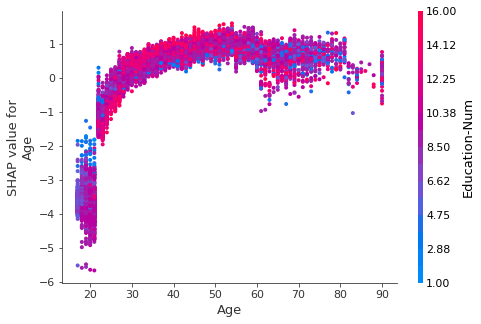

In [26]:
shap.dependence_plot('Age', shap_values, X, interaction_index='Education-Num')

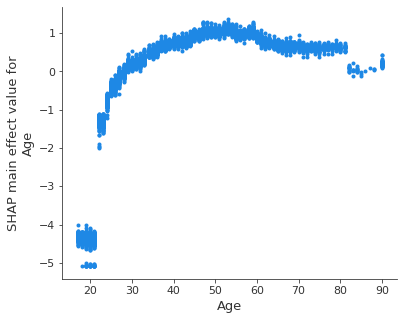

In [27]:
shap.dependence_plot(('Age', 'Age'), shap_interaction_values, X, interaction_index=None)

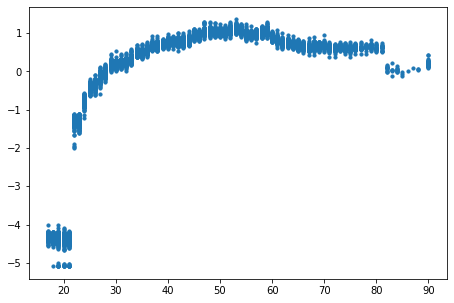

In [28]:
plt.figure(figsize=(7.5, 5))
plt.scatter(X['Age'], shap_interaction_values[:, 0, 0], s=10, alpha=1)